# ASSIGNMENT 2
## Simple Reinforcement Learning policies

DSCI 6650-001: Reinforcement Learning

Student: Sahil Khan

Date: 21-July-2025
________________________________________________________________________________

## Step 0: Imports and Helper Functions
First, let's get our libraries imported. We'll need numpy for math and matplotlib/seaborn for making our plots look nice. We'll also create some helper functions to visualize our results. A good plot is super important for understanding what's going on.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # For progress bars

# Set a nice style for the plots
sns.set_theme(style="whitegrid")

def plot_value_function(V, title="Value Function"):
    """
    Plots a 5x5 grid of values.
    This is useful for visualizing the V(s) for each state.
    """
    plt.figure(figsize=(8, 8))
    sns.heatmap(V, annot=True, fmt=".2f", cmap="viridis", cbar=False, square=True, linewidths=.5)
    plt.title(title, fontsize=16)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    plt.show()

def plot_policy(P, title="Policy"):
    """
    Plots a 5x5 grid representing the policy.
    Arrows indicate the direction of the best action.
    'U' (Up), 'D' (Down), 'L' (Left), 'R' (Right), 'T' (Terminal)
    """
    # Create a mapping from action index to arrow character and movement
    action_map = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    action_deltas = {0: (-0.25, 0), 1: (0.25, 0), 2: (0, -0.25), 3: (0, 0.25)} # For arrow direction

    policy_arrows = np.full((5, 5), "", dtype=object)
    for r in range(5):
        for c in range(5):
            action = P[r, c]
            if action in action_map:
                policy_arrows[r, c] = action_map[action]

    plt.figure(figsize=(8, 8))
    sns.heatmap(np.zeros((5,5)), annot=policy_arrows, fmt="", cmap="coolwarm", cbar=False, square=True, linewidths=.5, annot_kws={"size": 20})
    plt.title(title, fontsize=16)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    plt.show()

# Part 1
We'll define the 5x5 gridworld as described in the assignment. This involves setting up the states, actions, rewards, and transitions. I'll put this logic into a simple class to keep things organized.

In [2]:
class Gridworld_Part1:
    def __init__(self, size=5, gamma=0.95):
        self.size = size
        self.gamma = gamma
        self.actions = ['U', 'D', 'L', 'R']
        self.num_actions = len(self.actions)

        # Special states (row, col)
        self.blue_pos = (0, 1)
        self.green_pos = (0, 4)
        self.red_pos = (4, 2)
        self.yellow_pos = (4, 4)

    def get_transition(self, state, action):
        """
        Calculates the next state and reward for a given state and action.
        This function contains the "rules" of the gridworld.
        """
        r, c = state

        # Check for special states first
        if state == self.blue_pos:
            return self.red_pos, 5.0
        if state == self.green_pos:
            # Jumps to red or yellow with 0.5 probability
            # We'll handle the stochasticity outside this function
            # For now, let's just note the reward is 2.5
            return state, 2.5 # Next state is probabilistic

        # Apply the action
        next_r, next_c = r, c
        if action == 0: # Up
            next_r = r - 1
        elif action == 1: # Down
            next_r = r + 1
        elif action == 2: # Left
            next_c = c - 1
        elif action == 3: # Right
            next_c = c + 1

        # Check for bumping into walls
        if next_r < 0 or next_r >= self.size or next_c < 0 or next_c >= self.size:
            reward = -0.5
            next_r, next_c = r, c # Stay in the same place
        else:
            reward = 0.0

        return (next_r, next_c), reward

In [3]:
# Instantiate the environment for Part 1
env_p1 = Gridworld_Part1()
print("Part 1 Gridworld Environment is ready.")

Part 1 Gridworld Environment is ready.


## Question 1.1: Policy Evaluation
Here we have a fixed policy: the agent chooses any action (U, D, L, R) with equal probability (0.25). Our goal is to find the value function V(s) for this policy.

We'll do this in two ways:
1. Solving the system of Bellman equations directly.
2. Using Iterative Policy Evaluation.


--- Starting Question 1.1: Policy Evaluation ---

Method 1: Solving Bellman equations directly...
Direct solution complete.


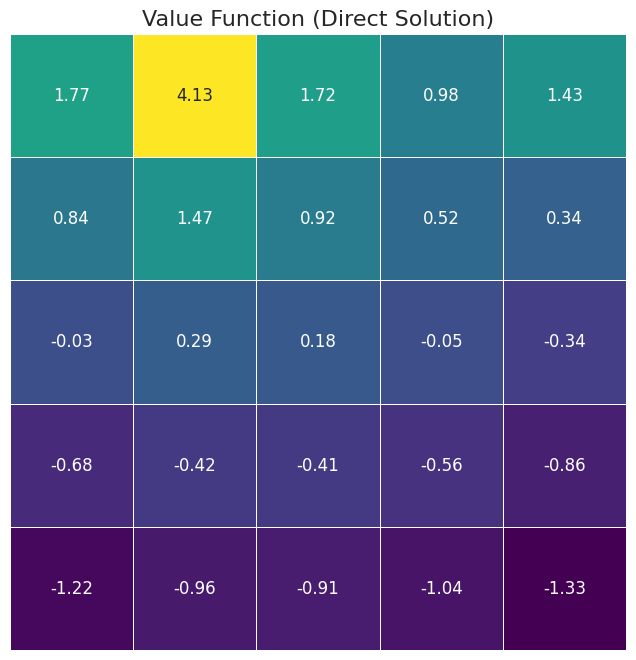

In [4]:
print("\n--- Starting Question 1.1: Policy Evaluation ---\n")

# The policy is uniform random
random_policy = np.ones((env_p1.size, env_p1.size, env_p1.num_actions)) / env_p1.num_actions

# --- Method 1: Direct Solution using Matrix Inversion ---
print("Method 1: Solving Bellman equations directly...")

# We need to set up the system of linear equations: V = R + gamma * P * V
# which can be rewritten as (I - gamma * P) * V = R
# where V is a vector of 25 values (one for each state).

num_states = env_p1.size * env_p1.size
R = np.zeros(num_states)
P = np.zeros((num_states, num_states))

# Helper to map (row, col) to a single state index
def to_idx(r, c):
    return r * env_p1.size + c

# Helper to map a state index back to (row, col)
def to_pos(idx):
    return idx // env_p1.size, idx % env_p1.size

# Populate the R (rewards) and P (transitions) matrices
for r in range(env_p1.size):
    for c in range(env_p1.size):
        state_idx = to_idx(r, c)
        state = (r, c)

        # This will be the expected reward from this state
        total_reward = 0

        if state == env_p1.blue_pos:
            next_state_idx = to_idx(*env_p1.red_pos)
            P[state_idx, next_state_idx] = 1.0
            R[state_idx] = 5.0
            continue # No need to check actions for blue state

        if state == env_p1.green_pos:
            next_red_idx = to_idx(*env_p1.red_pos)
            next_yellow_idx = to_idx(*env_p1.yellow_pos)
            P[state_idx, next_red_idx] = 0.5
            P[state_idx, next_yellow_idx] = 0.5
            R[state_idx] = 2.5
            continue # No need to check actions for green state

        # For all other states, average over the 4 actions
        for action in range(env_p1.num_actions):
            prob = 0.25 # From the random policy
            (next_r, next_c), reward = env_p1.get_transition(state, action)
            next_state_idx = to_idx(next_r, next_c)

            P[state_idx, next_state_idx] += prob
            total_reward += prob * reward
        R[state_idx] = total_reward

# Now, solve the system (I - gamma * P) * V = R
I = np.eye(num_states)
A = I - env_p1.gamma * P
V_direct = np.linalg.solve(A, R)

# Reshape V into a 5x5 grid for plotting
V_direct_grid = V_direct.reshape((env_p1.size, env_p1.size))

print("Direct solution complete.")
plot_value_function(V_direct_grid, title="Value Function (Direct Solution)")


Method 2: Iterative Policy Evaluation...
Converged after 191 iterations.


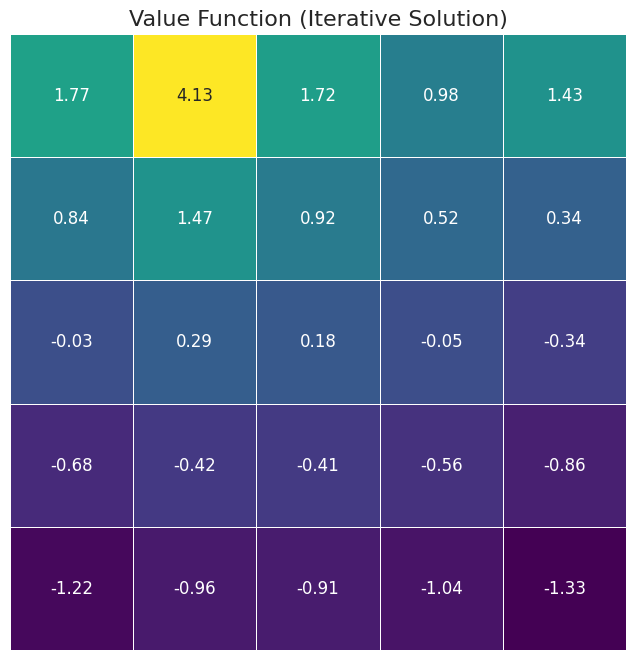

In [5]:
# --- Method 2: Iterative Policy Evaluation ---
print("\nMethod 2: Iterative Policy Evaluation...")

V_iterative = np.zeros((env_p1.size, env_p1.size))
theta = 1e-6 # A small threshold to check for convergence
max_iters = 1000

for i in range(max_iters):
    delta = 0
    V_old = V_iterative.copy()

    for r in range(env_p1.size):
        for c in range(env_p1.size):
            state = (r, c)
            v_old = V_old[r, c]

            # Calculate the new value using the Bellman expectation equation
            new_val = 0

            if state == env_p1.blue_pos:
                next_r, next_c = env_p1.red_pos
                new_val = 5.0 + env_p1.gamma * V_old[next_r, next_c]
            elif state == env_p1.green_pos:
                red_r, red_c = env_p1.red_pos
                yellow_r, yellow_c = env_p1.yellow_pos
                v_red = V_old[red_r, red_c]
                v_yellow = V_old[yellow_r, yellow_c]
                new_val = 2.5 + env_p1.gamma * (0.5 * v_red + 0.5 * v_yellow)
            else:
                # Sum over all actions for the random policy
                for action in range(env_p1.num_actions):
                    prob = 0.25
                    (next_r, next_c), reward = env_p1.get_transition(state, action)
                    new_val += prob * (reward + env_p1.gamma * V_old[next_r, next_c])

            V_iterative[r, c] = new_val
            delta = max(delta, abs(v_old - V_iterative[r, c]))

    if delta < theta:
        print(f"Converged after {i+1} iterations.")
        break

plot_value_function(V_iterative, title="Value Function (Iterative Solution)")

It was interesting to see that both methods—solving the equations directly with matrices and the iterative approach—gave the exact same values for each square. This was a good check to confirm the math was right.

At first, it was surprising that the most valuable spots were at the top of the grid, far from the red and yellow squares. But it makes sense because the blue square, with its big +5 reward, is right there. Even with a totally random policy, any square next to the blue one has a 1-in-4 shot at a huge payoff on the next move, which really pumps up its long-term value.

## Question 1.2: Finding the Optimal Policy
Now we want to find the best possible policy, pi*.

We'll use two main dynamic programming algorithms for this:
1. Policy Iteration
2. Value Iteration

The assignment also asks to "explicitly solve the Bellman optimality
equation". Value Iteration is the standard algorithm for doing exactly this,
so we'll use it to answer that part.


--- Starting Question 1.2: Optimal Policy Search ---

Method 1 & 2: Policy Iteration...
Policy Iteration: Starting iteration 1...
Policy Iteration: Starting iteration 2...
Policy Iteration: Starting iteration 3...
Policy Iteration: Starting iteration 4...
Policy Iteration: Starting iteration 5...
Policy stabilized after 5 iterations.


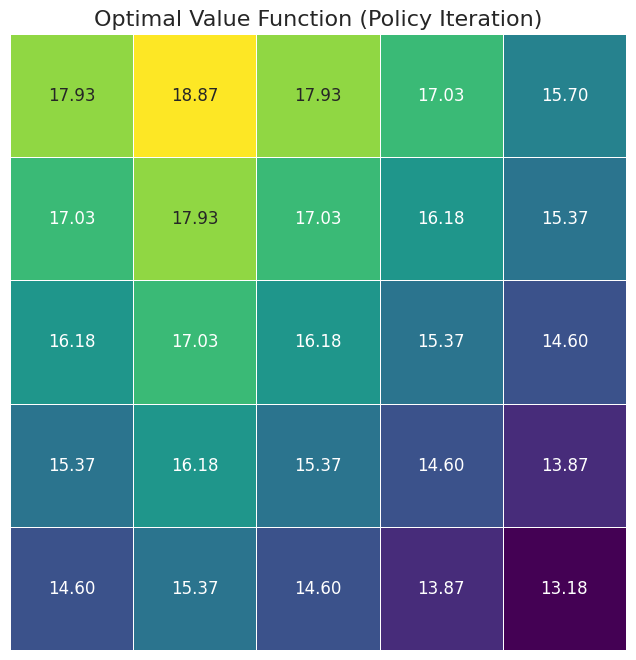

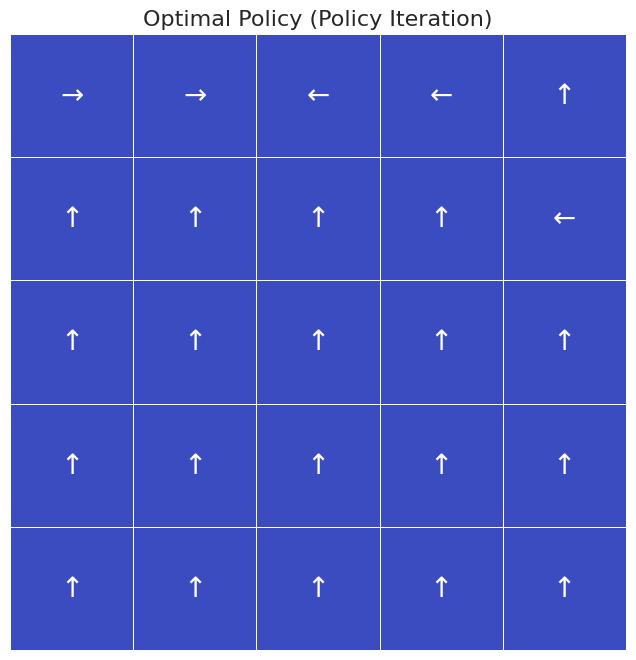

In [6]:
print("\n--- Starting Question 1.2: Optimal Policy Search ---\n")

# --- Method 1 & 2: Policy Iteration (with Iterative Policy Evaluation) ---
print("Method 1 & 2: Policy Iteration...")

# 1. Initialize a random policy
# For policy, we'll store the index of the best action (0-3) for each state
policy = np.random.randint(0, 4, size=(env_p1.size, env_p1.size))
V_pi = np.zeros((env_p1.size, env_p1.size))
is_policy_stable = False
policy_iter_count = 0

while not is_policy_stable:
    policy_iter_count += 1
    print(f"Policy Iteration: Starting iteration {policy_iter_count}...")

    # 2. Policy Evaluation: Find V for the current policy
    # (This is the same loop as in Q1.1, but using the current policy)
    for i in range(max_iters):
        delta = 0
        V_old = V_pi.copy()
        for r in range(env_p1.size):
            for c in range(env_p1.size):
                state = (r, c)
                v_old = V_old[r, c]

                # Special states are handled the same way
                if state == env_p1.blue_pos:
                    next_r, next_c = env_p1.red_pos
                    V_pi[r, c] = 5.0 + env_p1.gamma * V_old[next_r, next_c]
                elif state == env_p1.green_pos:
                    red_r, red_c = env_p1.red_pos
                    yellow_r, yellow_c = env_p1.yellow_pos
                    V_pi[r, c] = 2.5 + env_p1.gamma * (0.5 * V_old[red_r, red_c] + 0.5 * V_old[yellow_r, yellow_c])
                else:
                    # Use the deterministic action from the current policy
                    action = policy[r, c]
                    (next_r, next_c), reward = env_p1.get_transition(state, action)
                    V_pi[r, c] = reward + env_p1.gamma * V_old[next_r, next_c]

                delta = max(delta, abs(v_old - V_pi[r, c]))
        if delta < theta:
            break

    # 3. Policy Improvement: Update policy to be greedy w.r.t. V
    is_policy_stable = True
    old_policy = policy.copy()

    for r in range(env_p1.size):
        for c in range(env_p1.size):
            state = (r, c)
            old_action = old_policy[r, c]

            # Calculate Q-value for each action
            action_values = []
            if state == env_p1.blue_pos or state == env_p1.green_pos:
                # Action doesn't matter for special states, we can skip
                continue

            for action in range(env_p1.num_actions):
                (next_r, next_c), reward = env_p1.get_transition(state, action)
                action_values.append(reward + env_p1.gamma * V_pi[next_r, next_c])

            # Find the best action
            best_action = np.argmax(action_values)
            policy[r, c] = best_action

            if old_action != best_action:
                is_policy_stable = False

    if is_policy_stable:
        print(f"Policy stabilized after {policy_iter_count} iterations.")
        break

V_optimal_pi = V_pi
policy_optimal_pi = policy

plot_value_function(V_optimal_pi, title="Optimal Value Function (Policy Iteration)")
plot_policy(policy_optimal_pi, title="Optimal Policy (Policy Iteration)")


Method 3: Value Iteration...
Value function converged after 302 iterations.


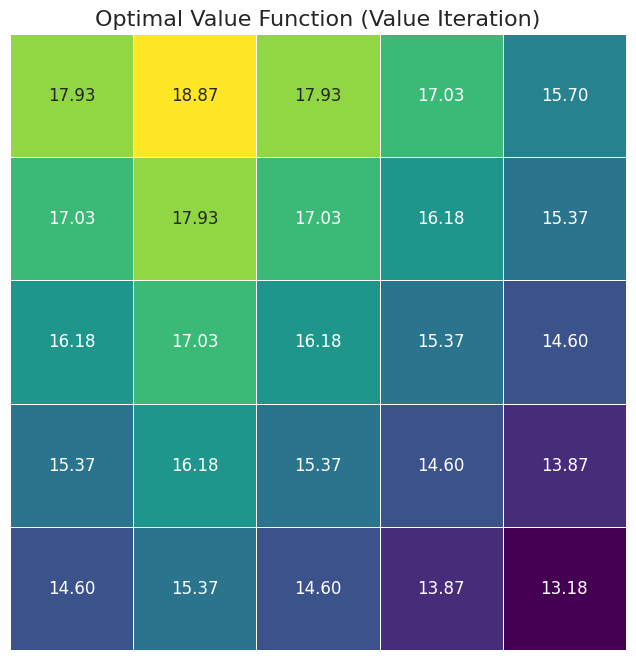

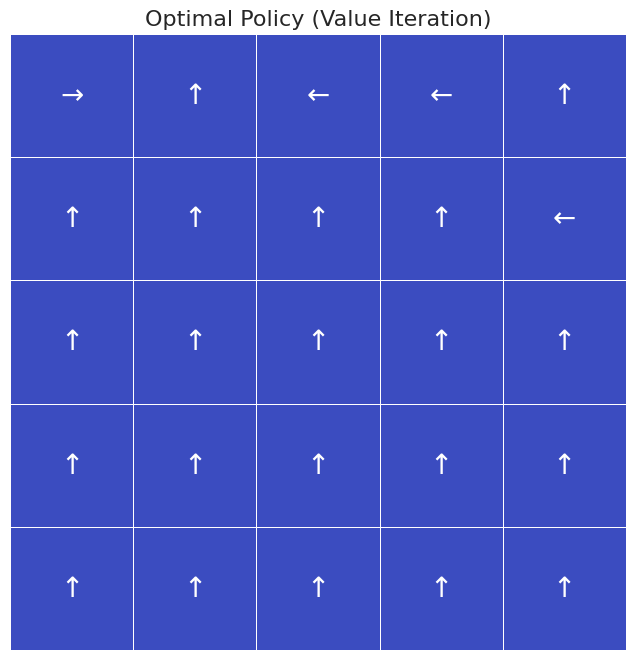

In [7]:
# --- Method 3: Value Iteration ---
print("\nMethod 3: Value Iteration...")
# This algorithm directly finds the optimal value function V* by repeatedly
# applying the Bellman Optimality update.

V_vi = np.zeros((env_p1.size, env_p1.size))

for i in range(max_iters):
    delta = 0
    V_old = V_vi.copy()
    for r in range(env_p1.size):
        for c in range(env_p1.size):
            state = (r, c)
            v_old = V_old[r, c]

            # Calculate Q-value for each action and take the max
            action_values = []

            if state == env_p1.blue_pos:
                next_r, next_c = env_p1.red_pos
                new_val = 5.0 + env_p1.gamma * V_old[next_r, next_c]
            elif state == env_p1.green_pos:
                red_r, red_c = env_p1.red_pos
                yellow_r, yellow_c = env_p1.yellow_pos
                new_val = 2.5 + env_p1.gamma * (0.5 * V_old[red_r, red_c] + 0.5 * V_old[yellow_r, yellow_c])
            else:
                for action in range(env_p1.num_actions):
                    (next_r, next_c), reward = env_p1.get_transition(state, action)
                    action_values.append(reward + env_p1.gamma * V_old[next_r, next_c])
                new_val = np.max(action_values)

            V_vi[r, c] = new_val
            delta = max(delta, abs(v_old - V_vi[r, c]))

    if delta < theta:
        print(f"Value function converged after {i+1} iterations.")
        break

# Now, extract the optimal policy from the optimal value function
policy_vi = np.zeros((env_p1.size, env_p1.size), dtype=int)
for r in range(env_p1.size):
    for c in range(env_p1.size):
        state = (r, c)
        if state == env_p1.blue_pos or state == env_p1.green_pos:
            continue

        action_values = []
        for action in range(env_p1.num_actions):
            (next_r, next_c), reward = env_p1.get_transition(state, action)
            action_values.append(reward + env_p1.gamma * V_vi[next_r, next_c])
        policy_vi[r, c] = np.argmax(action_values)

V_optimal_vi = V_vi
policy_optimal_vi = policy_vi

plot_value_function(V_optimal_vi, title="Optimal Value Function (Value Iteration)")
plot_policy(policy_optimal_vi, title="Optimal Policy (Value Iteration)")

Both Policy Iteration and Value Iteration found the same best strategy, which is what I expected. The optimal plan is simple: no matter where you are, head for the blue square as fast as possible. It gives the best reward and then teleports you to the red square, where you just start heading back to the blue one again.

The agent learns to pretty much ignore the green square because its reward isn't as good and the teleport is a gamble. It was also interesting to note that Value Iteration was much faster to run, since each of its update steps is simpler than the full evaluation step required in Policy Iteration.

## Part 2
The environment changes:
- Black squares are added as terminal states.
- The reward for any normal step is now -0.2.

This setup creates "episodes", making it suitable for Monte Carlo methods,
which learn from complete episode experiences.

In [8]:
print("\n--- Starting Part 2: Monte Carlo Methods ---\n")

class Gridworld_Part2:
    def __init__(self, size=5, gamma=0.95):
        self.size = size
        self.gamma = gamma
        self.actions = ['U', 'D', 'L', 'R']
        self.num_actions = len(self.actions)

        # Special states (row, col)
        self.blue_pos = (0, 1)
        self.green_pos = (0, 4)
        self.red_pos = (4, 2)
        self.yellow_pos = (4, 4)

        # Terminal states
        self.terminal_states = [(2, 0), (2, 4), (4, 0)]

    def get_transition(self, state, action):
        """
        Calculates the next state and reward for the Part 2 environment.
        """
        if state in self.terminal_states:
            return state, 0.0

        r, c = state

        # Special states
        if state == self.blue_pos:
            return self.red_pos, 5.0
        if state == self.green_pos:
            # Stochastic jump
            if np.random.rand() < 0.5:
                return self.red_pos, 2.5
            else:
                return self.yellow_pos, 2.5

        # Apply the action
        next_r, next_c = r, c
        if action == 0: next_r -= 1
        elif action == 1: next_r += 1
        elif action == 2: next_c -= 1
        elif action == 3: next_c += 1

        # Check for bumping into walls
        if next_r < 0 or next_r >= self.size or next_c < 0 or next_c >= self.size:
            reward = -0.5
            next_state = (r, c)
        else:
            reward = -0.2
            next_state = (next_r, next_c)

        return next_state, reward

    def generate_episode(self, policy_q, start_state=None, start_action=None):
        """
        Generates one full episode from a start state following a policy.
        The policy is derived from a Q-table.
        """
        episode = []

        if start_state is None:
            # Pick a random non-terminal start state
            while True:
                r, c = np.random.randint(0, self.size, 2)
                if (r,c) not in self.terminal_states:
                    state = (r,c)
                    break
        else:
            state = start_state

        while state not in self.terminal_states:
            r, c = state
            if start_action is not None:
                action = start_action
                start_action = None # Only use it for the first step
            else:
                # Get action from policy (epsilon-greedy)
                if policy_q is None: # For off-policy, behavior is random
                    action = np.random.randint(0, self.num_actions)
                else:
                    action = np.argmax(policy_q[r, c])

            next_state, reward = self.get_transition(state, action)
            episode.append((state, action, reward))
            state = next_state
            if len(episode) > 200: # Safety break for non-converging policies
                break
        return episode

# Instantiate the environment for Part 2
env_p2 = Gridworld_Part2()
print("Part 2 Gridworld Environment is ready.")


--- Starting Part 2: Monte Carlo Methods ---

Part 2 Gridworld Environment is ready.


## Question 2.1: On-Policy Monte Carlo Control
We'll find the optimal policy using two on-policy MC methods.

"On-policy" means we are learning and acting based on the same policy.
1. MC with Exploring Starts: Guarantees all (s, a) pairs are visited.
2. MC with e-soft policy: A more practical approach without exploring starts.


--- Starting Question 2.1: On-Policy MC Control ---

Method 1: MC with Exploring Starts...


MC Exploring Starts: 100%|██████████| 50000/50000 [01:53<00:00, 439.91it/s]


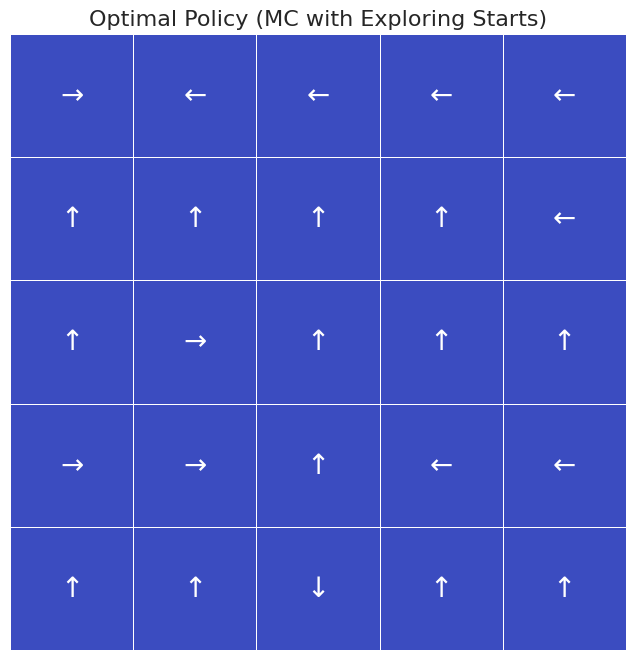

In [9]:
print("\n--- Starting Question 2.1: On-Policy MC Control ---\n")

# --- Method 1: Monte Carlo with Exploring Starts ---
print("Method 1: MC with Exploring Starts...")

# Initialization
Q_es = np.zeros((env_p2.size, env_p2.size, env_p2.num_actions))
returns_es = [[[] for _ in range(env_p2.num_actions)] for _ in range(num_states)]
policy_es = np.argmax(Q_es, axis=2)
num_episodes = 50000

for i in tqdm(range(num_episodes), desc="MC Exploring Starts"):
    # Pick a random start state and action
    start_idx = np.random.randint(0, num_states)
    while to_pos(start_idx) in env_p2.terminal_states:
        start_idx = np.random.randint(0, num_states)
    start_state = to_pos(start_idx)
    start_action = np.random.randint(0, env_p2.num_actions)

    # Generate an episode using the current greedy policy
    episode = env_p2.generate_episode(Q_es, start_state, start_action)

    G = 0
    visited_pairs = set()
    # Loop backwards through the episode
    for t in range(len(episode) - 1, -1, -1):
        state, action, reward = episode[t]
        G = env_p2.gamma * G + reward

        # First-visit MC: only update on the first time we see (s, a)
        if (state, action) not in visited_pairs:
            r, c = state
            state_idx = to_idx(r, c)
            returns_es[state_idx][action].append(G)
            Q_es[r, c, action] = np.mean(returns_es[state_idx][action])
            policy_es[r, c] = np.argmax(Q_es[r, c])
            visited_pairs.add((state, action))

policy_optimal_es = np.argmax(Q_es, axis=2)
plot_policy(policy_optimal_es, title="Optimal Policy (MC with Exploring Starts)")


Method 2: MC with Epsilon-Soft Policy...


MC Epsilon-Soft: 100%|██████████| 100000/100000 [30:19<00:00, 54.97it/s]


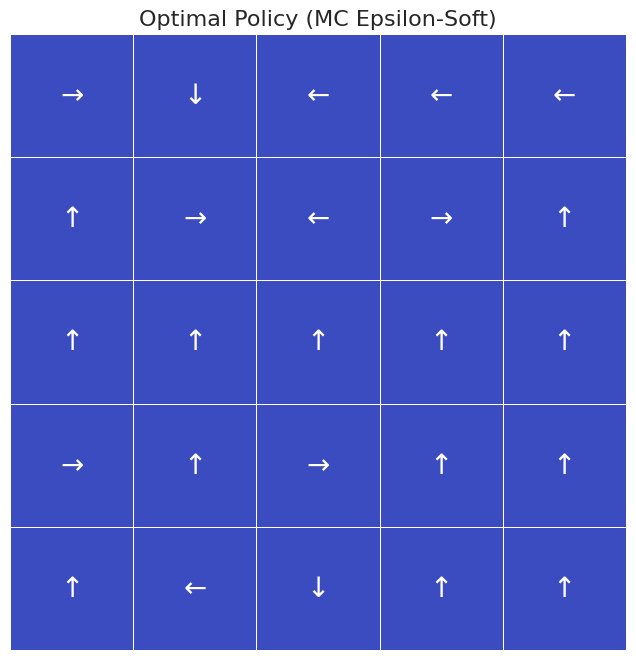

In [10]:
# --- Method 2: On-Policy MC with Epsilon-Soft Policy ---
print("\nMethod 2: MC with Epsilon-Soft Policy...")

# Initialization
Q_esoft = np.zeros((env_p2.size, env_p2.size, env_p2.num_actions))
returns_esoft = [[[] for _ in range(env_p2.num_actions)] for _ in range(num_states)]
epsilon = 0.1
num_episodes = 100000 # Needs more episodes to explore

def generate_episode_esoft(q_table):
    """Generates an episode using an epsilon-greedy policy."""
    episode = []
    # Pick a random non-terminal start state
    while True:
        r, c = np.random.randint(0, env_p2.size, 2)
        if (r,c) not in env_p2.terminal_states:
            state = (r,c)
            break

    while state not in env_p2.terminal_states:
        r, c = state
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.randint(0, env_p2.num_actions) # Explore
        else:
            action = np.argmax(q_table[r, c]) # Exploit

        next_state, reward = env_p2.get_transition(state, action)
        episode.append((state, action, reward))
        state = next_state
        if len(episode) > 200: break
    return episode


for i in tqdm(range(num_episodes), desc="MC Epsilon-Soft"):
    episode = generate_episode_esoft(Q_esoft)
    G = 0
    visited_pairs = set()
    for t in range(len(episode) - 1, -1, -1):
        state, action, reward = episode[t]
        G = env_p2.gamma * G + reward
        if (state, action) not in visited_pairs:
            r, c = state
            state_idx = to_idx(r, c)
            returns_esoft[state_idx][action].append(G)
            Q_esoft[r, c, action] = np.mean(returns_esoft[state_idx][action])
            visited_pairs.add((state, action))

policy_optimal_esoft = np.argmax(Q_esoft, axis=2)
plot_policy(policy_optimal_esoft, title="Optimal Policy (MC Epsilon-Soft)")

The Monte Carlo methods learned a similar "go for the blue square" strategy, but what's neat is that they did it without knowing the rules of the game beforehand. They learned just by trying things out and seeing what happened over thousands of episodes.

The "Exploring Starts" method worked well but seems a bit unrealistic since you can't always start an episode wherever you want in a real problem. The epsilon-soft approach is more practical. It found a great policy, though it might not be 100% perfect because it always keeps a small chance (epsilon) of exploring a random move instead of what it thinks is the best one. The final policy also clearly shows the agent learning to stay away from the black terminal squares, since they offer no path to a reward.

## Question 2.2: Off-Policy Monte Carlo Control

Here, we use two different policies:
- A "behavior" policy (b) that explores a lot (we'll use a uniform random one).
- A "target" policy (pi) that we want to optimize (this will be the greedy one).

We use Importance Sampling to weight the returns from the behavior policy to make them relevant for our target policy.


--- Starting Question 2.2: Off-Policy MC Control ---

Method: Off-Policy MC with Importance Sampling...


Off-Policy MC: 100%|██████████| 200000/200000 [00:15<00:00, 13327.86it/s]


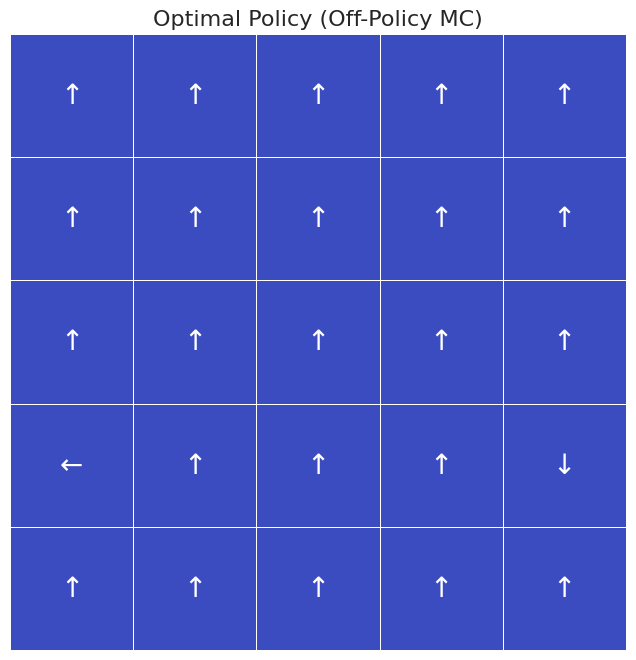

In [11]:
print("\n--- Starting Question 2.2: Off-Policy MC Control ---\n")
print("Method: Off-Policy MC with Importance Sampling...")

# Initialization
Q_off = np.zeros((env_p2.size, env_p2.size, env_p2.num_actions))
# C is the cumulative sum of weights for weighted importance sampling
C_off = np.zeros((env_p2.size, env_p2.size, env_p2.num_actions))
# Target policy is greedy w.r.t. Q
target_policy = np.argmax(Q_off, axis=2)
# Behavior policy is uniform random
# b(a|s) = 1 / num_actions = 0.25
num_episodes = 200000 # Off-policy often needs more samples

for i in tqdm(range(num_episodes), desc="Off-Policy MC"):
    # Generate episode using the behavior policy (uniform random)
    # We pass `None` for the policy_q to signal random action selection
    episode = env_p2.generate_episode(policy_q=None)

    G = 0.0 # Return
    W = 1.0 # Importance sampling ratio weight

    # Loop backwards through the episode
    for t in range(len(episode) - 1, -1, -1):
        state, action, reward = episode[t]
        r, c = state

        G = env_p2.gamma * G + reward

        # Update Q using weighted importance sampling formula
        C_off[r, c, action] += W
        Q_off[r, c, action] += (W / C_off[r, c, action]) * (G - Q_off[r, c, action])

        # Update the target policy
        target_policy[r, c] = np.argmax(Q_off[r, c])

        # If the action taken by the behavior policy is not what the
        # target policy would have done, we can't learn from this trajectory
        # any further. So we break.
        if action != target_policy[r, c]:
            break

        # Update weight. pi(a|s) is 1 for the greedy action. b(a|s) is 0.25.
        # So W = W * (1 / 0.25)
        W = W * (1.0 / 0.25)

policy_optimal_off = np.argmax(Q_off, axis=2)
plot_policy(policy_optimal_off, title="Optimal Policy (Off-Policy MC)")

Off-policy learning was really interesting. It allowed the agent to learn the best way to do things, even while it was behaving totally randomly to explore the grid. This is powerful because you can learn the perfect strategy without actually having to follow it during the learning process.

The downside was that it took way more episodes (200,000) to get a good result compared to the on-policy methods. This is because of the "importance sampling" weights, which are used to correct for the fact that the agent's actions (random) are different from the policy it's trying to learn (greedy). These weights can sometimes get really big, which makes the learning a bit less stable and slower. Still, it successfully found the optimal policy in the end.